In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# extracting data and doing the fit on velocity

In [2]:
from ANEMO.edfreader import read_edf

import pickle
with open('../demo/result/param_Fit_AM.pkl', 'rb') as fichier:
    param = pickle.load(fichier, encoding='latin1')
with open('../demo/data/enregistrement_AM_2017-10-23_100057.pkl', 'rb') as fichier:
    file_exp = pickle.load(fichier, encoding='latin1')

datafile = '../demo/data/enregistrement_AM_2017-10-23_100057.asc'
file_data = read_edf(datafile, 'TRIALID')

In [3]:
block = 0
trial = 140

from ANEMO import ANEMO
arg = ANEMO.arg(file_data, file_exp, trial, block)

N_trials = arg.N_trials

time = arg.trackertime
t_0 = arg.trackertime_0

trial_data = trial + N_trials*block

data_x = arg.data_x -(arg.data_x[arg.StimulusOf-t_0])
#data_x = arg.data_x-(arg.screen_width_px/2)

start = arg.TargetOn
start1 = arg.TargetOn-t_0

In [4]:
def deco(axs) :
    axs.axvspan(arg.StimulusOn-start, arg.StimulusOf-start, color='k', alpha=0.2)
    axs.axvspan(arg.StimulusOf-start, arg.TargetOn-start, color='r', alpha=0.2)
    axs.axvspan(arg.TargetOn-start, arg.TargetOff-start, color='k', alpha=0.15)
    for s in range(len(arg.saccades)) :
        axs.axvspan(arg.saccades[s][0]-start, arg.saccades[s][1]-start, color='k', alpha=0.2)

In [5]:
def position(x, bino, start_anti, v_anti, latence, tau, maxi, nan=False, do_numpy=True):
    
    #gradient_deg = gradient_x * 1/px_per_deg * 1000 # gradient en deg/sec
    ms = 1000
    v_anti = (v_anti/1000) #/ms # pour passer de sec à ms
    maxi = maxi /ms
    
    speed = ANEMO.fct_velocity(x, bino, start_anti, v_anti, latence, tau, maxi)
    pos = np.cumsum(speed)

    if nan == True :
        avant, apres =  5, 10 #15
        for sacc in arg.saccades :
            if sacc[0]-t_0 > int(latence) :
                # [starttime, endtime, duration, startx, starty, endx, endy]
                #pos[int(sacc[1]-t_0+1):] += (sacc[5]-sacc[3])/ exp['px_per_deg'] - np.sum(speed[int(sacc[0]-t_0):int(sacc[1]-t_0)]) * sacc[2]
                pos[int(sacc[0]-t_0)-avant:int(sacc[1]-t_0)+apres] = np.nan 
                pos[int(sacc[1]-t_0)+apres:] += ((data_x[int(sacc[1]-t_0)+apres]-data_x[int(sacc[0]-t_0)-avant-1])/ arg.px_per_deg) - np.mean(speed[int(sacc[0]-t_0):int(sacc[1]-t_0)]) * sacc[2]

 
    return pos

In [6]:
data = np.copy(data_x)
  
avant, apres =  5, 10 #15
for s in range(len(arg.saccades)) :
    if arg.saccades[s][1]-t_0+apres <= (len(time)) :
        for x_data in np.arange((arg.saccades[s][0]-t_0-avant), (arg.saccades[s][1]-t_0+apres)) :
            data[x_data] = np.nan
    else :
        for x_data in np.arange((arg.saccades[s][0]-t_0-avant), (len(time))) :
            data[x_data] = np.nan
            
a = 0

for sacc in arg.saccades :
    a = (data_x[int(sacc[1]-t_0)+apres]-data_x[int(sacc[0]-t_0)-avant-1])
    b = ((data_x[int(sacc[0]-t_0)-avant-1]-data_x[int(sacc[0]-t_0)-avant-11])/10)
    data[int(sacc[1]-t_0+apres):] += - a + ((sacc[1]-t_0+apres)-(sacc[0]-t_0-avant)) * b
            
data = data - data[arg.StimulusOf-t_0]

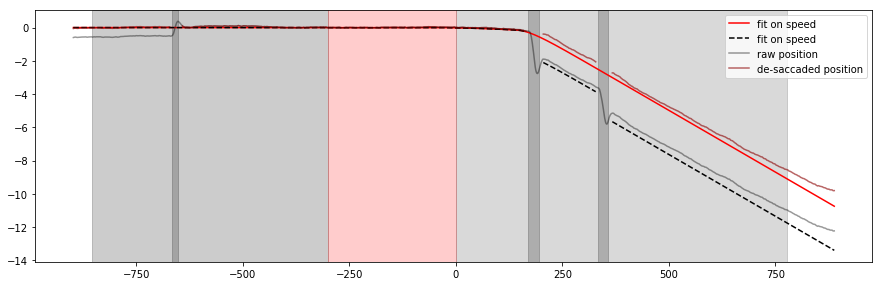

In [7]:
fig_width = 15
fig, axs = plt.subplots(1, 1, figsize=(fig_width, (fig_width/2)/1.6180))
deco(axs)

a = position(np.arange(len(time)), arg.bino, param['start_anti'][block][trial]+start1,
             param['v_anti'][block][trial], param['latence'][block][trial]+start1,
             param['tau'][block][trial], param['maxi'][block][trial]) 
axs.plot(time-start, a-np.ones(len(a))*(a[arg.StimulusOf-t_0]), c='r', label='fit on speed')

b = position(np.arange(len(time)), arg.bino, param['start_anti'][block][trial]+start1,
             param['v_anti'][block][trial], param['latence'][block][trial]+start1,
             param['tau'][block][trial], param['maxi'][block][trial], nan=True)
axs.plot(time-start, b-np.ones(len(b))*(b[arg.StimulusOf-t_0]), '--k', label='fit on speed')


axs.plot(time-start, data_x / arg.px_per_deg, color='k', alpha=0.4, label='raw position')
axs.plot(time-start, data / arg.px_per_deg , color='darkred', alpha=0.6, label='de-saccaded position')
axs.legend();

# doing the fit

In [8]:
def Fit_position(velocity_x, trackertime, bino, param_fit=None, TargetOn=arg.TargetOn,
                 StimulusOf=arg.StimulusOf, saccades=arg.saccades, sup=False, time_sup=-280, step=2,
                 nan=True) :

    from lmfit import  Model, Parameters

    t_0 = trackertime[0]

    if param_fit is None :
        param_fit={'tau':[15.,13.,80.], 'maxi':[15.,1.,40], 'v_anti':[0.,-100.,100.],
                   'latence':[TargetOn-t_0+100, TargetOn-t_0+75,'STOP'],
                   'start_anti':[TargetOn-t_0-100, StimulusOf-t_0-200, TargetOn-t_0+75]} #'v_anti':[0.,-40.,40.]

    if param_fit['latence'][2]=='STOP' :
        stop_latence = []
        for s in range(len(saccades)) :
            if (saccades[s][0]-t_0) >= (TargetOn-t_0+100) :
                stop_latence.append((saccades[s][0]-t_0))
        if stop_latence==[] :
            stop_latence.append(len(trackertime))
        stop = stop_latence[0]
    else :
        stop = param_fit['latence'][2]


    if sup==True :
        velocity_x = velocity_x[:time_sup]
        trackertime = trackertime[:time_sup]
    
    model = Model(position)

    params = Parameters()

    if step == 1 :
        vary = True
    elif step == 2 :
        vary = False

    params.add('nan', value=nan, vary=False)
    params.add('bino', value=bino, vary=False)
    
    params.add('maxi', value=param_fit['maxi'][0], min=param_fit['maxi'][1], max=param_fit['maxi'][2])
    params.add('latence', value=param_fit['latence'][0], min=param_fit['latence'][1], max=stop)
    params.add('tau', value=param_fit['tau'][0], min=param_fit['tau'][1], max=param_fit['tau'][2], vary=vary)
    params.add('start_anti', value=param_fit['start_anti'][0], min=param_fit['start_anti'][1], max=param_fit['start_anti'][2], vary=vary)
    params.add('v_anti', value=param_fit['v_anti'][0], min=param_fit['v_anti'][1], max=param_fit['v_anti'][2], vary=vary)

    if step == 1 :
        result_deg = model.fit(velocity_x, params, x=np.arange(len(trackertime)), nan_policy='omit')

    elif step == 2 :
        out = model.fit(velocity_x, params, x=np.arange(len(trackertime)), nan_policy='omit')
        out.params['tau'].set(vary=True)
        out.params['start_anti'].set(vary=True)
        out.params['v_anti'].set(vary=True)

        result_deg = model.fit(velocity_x, out.params, x=np.arange(len(trackertime)), method='nelder', nan_policy='omit')
                                
    return result_deg


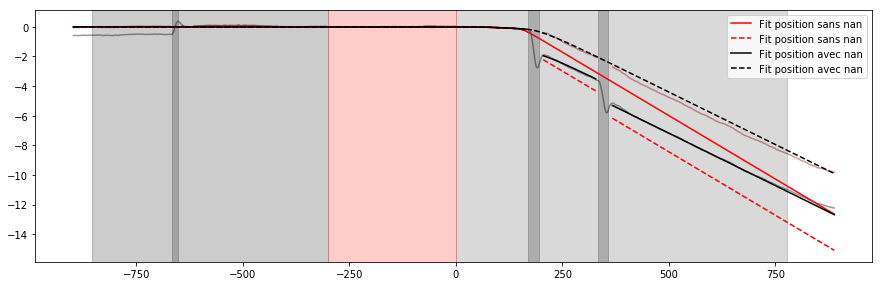

In [9]:
fig_width= 15
fig, axs = plt.subplots(1, 1, figsize=(fig_width, (fig_width/2)/1.6180))
deco(axs)

#gradient_deg = gradient_x * 1/px_per_deg * 1000 # gradient en deg/sec
data_2 = np.copy(data)
data_2 /= arg.px_per_deg

data_1 = np.copy(data_x)
data_1 /= arg.px_per_deg

axs.plot(time-start, data_1, color='k', alpha=0.4)
axs.plot(time-start, data_2 , color='darkred', alpha=0.4)


a = Fit_position(data_2,time, arg.bino,step=1, sup=True, time_sup=-280, nan=False)
b = position(np.arange(len(time)), arg.bino, a.values['start_anti'], a.values['v_anti'], a.values['latence'], a.values['tau'], a.values['maxi'])
f = position(np.arange(len(time)), arg.bino, a.values['start_anti'], a.values['v_anti'], a.values['latence'],
              a.values['tau'], a.values['maxi'], nan=True)
axs.plot(time-start, b , c='r', label='Fit position sans nan')
axs.plot(time-start, f , '--r', label='Fit position sans nan')

c = Fit_position(data_1,time, arg.bino,step=1, sup=True, time_sup=-280, nan=True)
d = position(np.arange(len(time)), arg.bino, c.values['start_anti'], c.values['v_anti'],
             c.values['latence'], c.values['tau'], c.values['maxi'], nan=True)
e = position(np.arange(len(time)), arg.bino, c.values['start_anti'], c.values['v_anti'],
             c.values['latence'], c.values['tau'], c.values['maxi'], nan=False)

axs.plot(time-start, d , 'k', label='Fit position avec nan')
axs.plot(time-start, e , '--k', label='Fit position avec nan')
axs.legend();

In [10]:
print('start_anti : %0.3f    a -> %0.3f, c -> %0.3f'%(param['start_anti'][block][trial], a.values['start_anti']-start1, c.values['start_anti']-start1), 
      '\nv_anti : %0.3f    a -> %0.3f, c -> %0.3f'%(param['v_anti'][block][trial], a.values['v_anti'], c.values['v_anti']), 
      '\nlatence : %0.3f    a -> %0.3f, c -> %0.3f'%(param['latence'][block][trial], a.values['latence']-start1, c.values['latence']-start1),
      '\ntau : %0.3f    a -> %0.3f, c -> %0.3f'%(param['tau'][block][trial], a.values['tau'], c.values['tau']),
      '\nmaxi : %0.3f    a -> %0.3f, c -> %0.3f'%(param['maxi'][block][trial], a.values['maxi'], c.values['maxi']))

start_anti : -69.000    a -> 14.421, c -> 9.990 
v_anti : -6.882    a -> -13.706, c -> -12.604 
latence : 145.107    a -> 145.666, c -> 163.023 
tau : 33.851    a -> 13.000, c -> 42.865 
maxi : 13.375    a -> 15.344, c -> 12.244


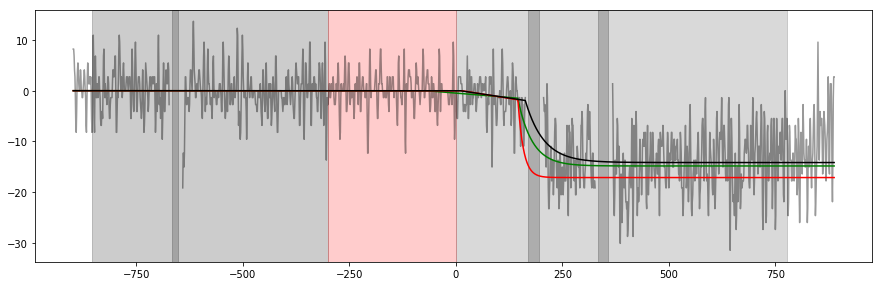

In [11]:
fig_width= 15
fig, axs = plt.subplots(1, 1, figsize=(fig_width, (fig_width/2)/1.6180))
deco(axs)

axs.plot(time-start, ANEMO.velocity_deg(data, arg.px_per_deg), color='k', alpha=0.4)

exp0 = ANEMO.fct_velocity(np.arange(len(time)), arg.bino, param['start_anti'][block][trial]+arg.TargetOn-t_0, param['v_anti'][block][trial],
                          param['latence'][block][trial]+arg.TargetOn-t_0, param['tau'][block][trial], param['maxi'][block][trial])
exp1 = ANEMO.fct_velocity(np.arange(len(time)), arg.bino, a.values['start_anti'], a.values['v_anti'],
                          a.values['latence'], a.values['tau'], a.values['maxi'])
exp2 = ANEMO.fct_velocity(np.arange(len(time)), arg.bino, c.values['start_anti'], c.values['v_anti'],
                          c.values['latence'], c.values['tau'], c.values['maxi'])


axs.plot(time-start, exp0 , c='g')
axs.plot(time-start, exp1 , c='r')
axs.plot(time-start, exp2 , c='k');

# Residu!

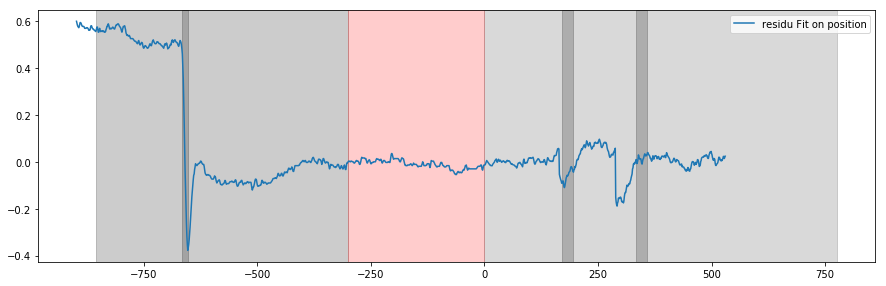

In [12]:
fig_width= 15
fig, axs = plt.subplots(1, 1, figsize=(fig_width, (fig_width/2)/1.6180))
deco(axs)
axs.plot(np.arange(len(c.residual))-start1, c.residual ,label='residu Fit on position')
axs.legend();